<a href="https://colab.research.google.com/github/p33ves/CMPT726-ML-Project/blob/main/k_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Nearest Neighbors(k-NN) Model


In [1]:
import pandas as pd
import numpy as np
import math
import json

from sklearn.preprocessing import OrdinalEncoder
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier 


from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Loading dataset from Github repo

In [2]:
full_dataset_url = "https://raw.githubusercontent.com/p33ves/CMPT726-ML-Project/main/processed_datasets/xtr_profile.csv"
data = pd.read_csv(full_dataset_url)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   gender                              14825 non-null  object 
 1   age                                 14825 non-null  int64  
 2   cust_id                             14825 non-null  object 
 3   became_member_on                    14825 non-null  object 
 4   income                              14825 non-null  float64
 5   days_as_member                      14825 non-null  int64  
 6   Total offer completed               14825 non-null  float64
 7   Total offer received                14825 non-null  float64
 8   Total offer viewed                  14825 non-null  float64
 9   Total transaction                   14825 non-null  float64
 10  offer completed_via_email           14825 non-null  float64
 11  offer completed_via_social          14825

Finding categorical features and Encoding

In [3]:
data.select_dtypes(include=[object])

,gender,cust_id,became_member_on
0,F,0610b486422d4921ae7d2bf64640c50b,2017-07-15
1,F,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09
2,M,e2127556f4f64592b11af22de27a7932,2018-04-26
3,M,389bc3fa690240e798340f5a15918d5c,2018-02-09
4,M,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11
...,...,...,...
14820,F,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04
14821,M,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13
14822,M,01d26f638c274aa0b965d24cefe3183f,2017-01-26
14823,F,9dc1421481194dcd9400aec7c9ae6366,2016-03-07


Selecting partial dataset

In [4]:
# define dataset
gen_split = pd.get_dummies(data['gender'], prefix='is_')
# data['income_in_k'] = data['income']/1000
data = pd.concat([data, gen_split], axis=1)
# data = data.drop('income', axis=1)
data = data.drop('is__O', axis=1)
data.drop('gender', axis=1, inplace=True)
data.sample(10)

,age,cust_id,became_member_on,income,days_as_member,Total offer completed,Total offer received,Total offer viewed,Total transaction,offer completed_via_email,offer completed_via_social,offer completed_via_mobile,offer completed_via_web,offer completed bogo count,offer completed discount count,offer received_via_email,offer received_via_social,offer received_via_mobile,offer received_via_web,offer received bogo count,offer received discount count,offer received informational count,offer viewed_via_email,offer viewed_via_social,offer viewed_via_mobile,offer viewed_via_web,offer viewed bogo count,offer viewed discount count,offer viewed informational count,Total transaction amount,avg_difficulty,avg_duration,total_reward_received,total_reward_defined,total_view_ratio,total_completion_ratio,avg_transaction_amt,transactions_per_membership_days,is__F,is__M
408,60,efeaf350ca114cf685a0e15c482b74fa,2016-09-06,74000.0,1542,3.0,5.0,3.0,5.0,3.0,2.0,3.0,2.0,2.0,1.0,5.0,3.0,5.0,3.0,3.0,1.0,1.0,3.0,3.0,3.0,1.0,2.0,1.0,0.0,89.35,7.363636,161.454545,18.0,28.0,0.60,0.6,17.87,0.003243,1,0
4437,27,6fbd611055b84f45bb23eb003742207c,2017-04-15,67000.0,1321,0.0,4.0,2.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,4.0,1.0,3.0,0.0,1.0,2.0,2.0,2.0,0.0,2.0,0.0,0.0,47.90,8.333333,156.000000,0.0,30.0,0.50,0.0,2.66,0.013626,0,1
14101,29,35047ada557b416395fdb9e342c97c6f,2018-03-30,56000.0,972,1.0,5.0,5.0,9.0,1.0,1.0,1.0,1.0,0.0,1.0,5.0,5.0,5.0,4.0,4.0,1.0,0.0,5.0,5.0,5.0,4.0,4.0,1.0,0.0,26.08,8.272727,141.818182,3.0,38.0,1.00,0.2,2.90,0.009259,0,1
5575,75,66e5459d394e418f94411e88ff43f8da,2015-12-25,36000.0,1798,3.0,3.0,1.0,14.0,3.0,2.0,3.0,3.0,2.0,1.0,3.0,2.0,3.0,3.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,120.75,7.285714,154.285714,18.0,18.0,0.33,1.0,8.63,0.007786,1,0
14267,58,cea7a0db90ea468b9b9d2e74884066b1,2017-08-06,113000.0,1208,2.0,4.0,3.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,4.0,2.0,3.0,4.0,1.0,3.0,0.0,3.0,2.0,3.0,3.0,1.0,2.0,0.0,53.50,11.111111,176.000000,12.0,19.0,0.75,0.5,17.83,0.002483,0,1
11585,51,87c14d061aad41638bc2d153158b008f,2015-10-26,51000.0,1858,5.0,5.0,4.0,22.0,5.0,4.0,5.0,4.0,2.0,3.0,5.0,4.0,5.0,4.0,2.0,3.0,0.0,4.0,3.0,4.0,3.0,1.0,3.0,0.0,280.67,8.714286,161.142857,28.0,28.0,0.80,1.0,12.76,0.011841,1,0
12579,58,047db31ef98140149f97667abee20860,2018-06-10,51000.0,900,0.0,6.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,3.0,5.0,6.0,2.0,4.0,0.0,3.0,2.0,3.0,3.0,1.0,2.0,0.0,9.18,8.777778,160.000000,0.0,22.0,0.50,0.0,1.02,0.010000,0,1
10900,59,3cc622f76e464bc1809a71e871579d6c,2017-08-20,44000.0,1194,1.0,1.0,0.0,10.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.43,10.000000,168.000000,2.0,2.0,0.00,1.0,8.64,0.008375,0,1
2468,62,30bed78a8a3e4a5ca596a84c0e7da8a1,2017-10-17,73000.0,1136,4.0,4.0,4.0,10.0,4.0,1.0,3.0,4.0,1.0,3.0,4.0,1.0,3.0,4.0,1.0,3.0,0.0,4.0,1.0,3.0,4.0,1.0,3.0,0.0,209.04,11.250000,204.000000,14.0,14.0,1.00,1.0,20.90,0.008803,1,0
6552,58,d3c01d3f66d142df959c19fb8bef8af9,2016-07-29,93000.0,1581,4.0,5.0,3.0,7.0,4.0,2.0,3.0,4.0,0.0,4.0,5.0,2.0,4.0,5.0,0.0,4.0,1.0,3.0,2.0,3.0,3.0,0.0,2.0,1.0,156.02,8.500000,168.000000,13.0,13.0,0.60,0.8,22.29,0.004428,0,1


Adding label

In [5]:
data['customer_type'] = "passive"
data.loc[(data['total_view_ratio'] >= 0.6) & (data['total_completion_ratio'] >= 0.2), 'customer_type'] = "active" 
data['customer_type'].value_counts()

active     9637
passive    5188
Name: customer_type, dtype: int64

Feature / Taget Define

In [6]:
# define dataset
X = data[[
          'avg_difficulty', 
          'avg_duration', 
          'avg_transaction_amt', 
          'transactions_per_membership_days', 
          'days_as_member'
          ]].to_numpy()

# # Encoding non-numerical labels(target) to numerical labels
# le = LabelEncoder()
# y = le.fit_transform(data['customer_type'])

y = data['customer_type']
y = y.replace(to_replace='active', value = 0)
y = y.replace(to_replace='passive', value = 1)

In [7]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

from imblearn.over_sampling import SMOTE

#Applying SMOTE to oversample the minority class before modeling
oversample = SMOTE(random_state = 101)
X_train, y_train = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [8]:
knn = KNeighborsClassifier()
sc = StandardScaler()
sc.fit_transform(X_train)
knn.fit(X_train, y_train)
print('Accuracy: {}'.format(knn.score(X_test, y_test)))

Accuracy: 0.6691399662731872


In [9]:
error_rate = []

for i in range(1, 40):
    steps2 = [('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier(metric='manhattan'))]
    parameters2 = {'knn__n_neighbors': [i]}
    pipeline2 = Pipeline(steps2)
    gcv2 = GridSearchCV(pipeline2, param_grid=parameters2, cv=5, verbose=0, n_jobs=-1)
    gcv2.fit(X_train, y_train)
    pred_i = gcv2.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

In [10]:
error_rate.index(min(error_rate))

19

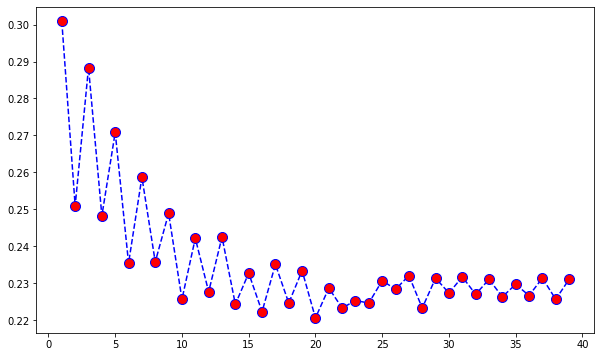

In [11]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate, color = 'blue', linestyle='dashed', marker = 'o', markerfacecolor = 'red', markersize = 10)

In [12]:
sc = StandardScaler()
sc.fit_transform(X)
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=19)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy: {}".format(knn.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy: 0.7129848229342327
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      1942
           1       0.58      0.63      0.60      1023

    accuracy                           0.71      2965
   macro avg       0.69      0.69      0.69      2965
weighted avg       0.72      0.71      0.72      2965



[[0.75437693 0.24562307]
 [0.3655914  0.6344086 ]]


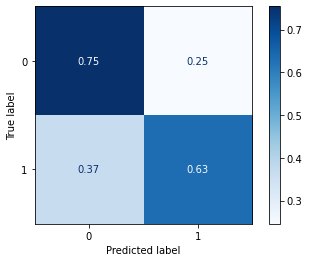

In [13]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(knn, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
print(disp.confusion_matrix)

plt.show()

In [14]:
# define models and parameters
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

model = KNeighborsClassifier()
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski','auto']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
# define grid search
grid = dict(weights=weights,metric=metric, algorithm=algorithm)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.733087 using {'algorithm': 'auto', 'metric': 'manhattan', 'weights': 'uniform'}
0.731243 (0.008439) with: {'algorithm': 'auto', 'metric': 'euclidean', 'weights': 'uniform'}
0.726993 (0.008465) with: {'algorithm': 'auto', 'metric': 'euclidean', 'weights': 'distance'}
0.733087 (0.009880) with: {'algorithm': 'auto', 'metric': 'manhattan', 'weights': 'uniform'}
0.728297 (0.009689) with: {'algorithm': 'auto', 'metric': 'manhattan', 'weights': 'distance'}
0.731243 (0.008439) with: {'algorithm': 'auto', 'metric': 'minkowski', 'weights': 'uniform'}
0.726993 (0.008465) with: {'algorithm': 'auto', 'metric': 'minkowski', 'weights': 'distance'}
0.000000 (0.000000) with: {'algorithm': 'auto', 'metric': 'auto', 'weights': 'uniform'}
0.000000 (0.000000) with: {'algorithm': 'auto', 'metric': 'auto', 'weights': 'distance'}
0.731243 (0.008439) with: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'weights': 'uniform'}
0.726993 (0.008465) with: {'algorithm': 'ball_tree', 'metric': 'euclidean', 

In [15]:
sc = StandardScaler()
sc.fit_transform(X)
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=19)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy: {}".format(knn.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy: 0.7129848229342327
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      1942
           1       0.58      0.63      0.60      1023

    accuracy                           0.71      2965
   macro avg       0.69      0.69      0.69      2965
weighted avg       0.72      0.71      0.72      2965

